## **Import statements and set random seed**

In [1]:
# import time
import time
t1 = time.time()

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

**Set random seed of numpy and tensorflow to make the result reproducible**

In [3]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 88
tf_rand_seed = 33
np.random.seed(np_rand_seed)
# print("random seed of numpy: ", np_rand_seed)
# print("random seed of tensorflow: ", tf_rand_seed)

# **Loading training data**

**Load data**

In [4]:
# read the train data
train_data = pd.read_csv('../input/train.csv')

In [5]:
print("shape of train_data:",train_data.shape)

shape of train_data: (42000, 785)


In [6]:
# display the head of data
train_data.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Feature engineer data**

In [7]:
# extract features and output 
features = train_data.columns.tolist()
output = "label"
features.remove(output)

In [8]:
# image dimensions
width = 28
height = 28

In [9]:
# extract feature matrix
train_X = train_data[features].as_matrix()
train_X = train_X/255.0
# reshape the data into image
train_X = train_X.reshape((-1, 28,28))

In [10]:
# extract labels
train_y = train_data[output].as_matrix()
train_y = train_y.astype(int)
# one hot enncode the labels
train_y = pd.get_dummies(train_y).as_matrix()

In [11]:
print("shape of train_X:",train_X.shape)

shape of train_X: (42000, 28, 28)


In [12]:
print("shape of train_y:",train_y.shape)

shape of train_y: (42000, 10)


**Train validation split**

In [13]:
# generate training and validation indexes
train_indices = np.random.choice(len(train_y), round(len(train_y)*0.95), replace=False)
validation_indices = np.array(list(set(range(len(train_y))) - set(train_indices)))
# extract images for train and validation set
image_train = train_X[train_indices]
image_validation = train_X[validation_indices]
# extract labels for train and validation set
labels_train = train_y[train_indices]
labels_validation = train_y[validation_indices]

# **Augment Training set**

** Image Rotation**

In [14]:
def rotate_image(img, angle = 20):
    
    '''a function to rotate image by a given degree'''
    
    # rotate image
    copy = img.copy()

    M_rotate = cv2.getRotationMatrix2D((14,14),angle,1)
    img_new = cv2.warpAffine(copy,M_rotate,(28,28))

    return img_new

**Horizontal translation**

In [15]:
def translate_horizontal(image, shift_horizontal = 5):
    
    '''a function to translate image horizontally by a shift'''
    
    # horizontally shift image
    img = image.copy()
    
    shift_vertical = 0
    M_translate = np.float32([[1,0,shift_horizontal],[0,1,shift_vertical]])
    img_new = cv2.warpAffine(img,M_translate,(28,28))
    
    return img_new.reshape(28,28).astype(np.float32)

**Vertical translation**

In [16]:
def translate_vertical(image, shift_vertical = 5):
    
    '''a function to translate image vertically by a shift'''
    
    # vertically shift image
    img = image.copy()
    
    shift_horizontal = 0;
    if shift_vertical<0:
        image_slice = img[shift_vertical:,:].copy()
    if shift_vertical>0:
        image_slice = img[:shift_vertical,:].copy()
    M_translate = np.float32([[1,0,shift_horizontal],[0,1,shift_vertical]])
    img_new = cv2.warpAffine(img,M_translate,(28,28))
    
    return img_new.reshape(28,28).astype(np.float32)

**Translation along positive diagonal**

In [17]:
def translate_positive_diagonal(image, shift_diagonal = 5):
    
    '''a function to translate image along positive diagonal'''
    
    # translate image along positive diagonal
    img = image.copy()
    
    if shift_diagonal<0:
        hor_slice = img[shift_diagonal:,:].copy()
        ver_slice = img[:,shift_diagonal:].copy()
    else:
        hor_slice = img[:shift_diagonal,:].copy()
        ver_slice = img[:,:shift_diagonal].copy()
    M_translate = np.float32([[1,0,shift_diagonal],[0,1,shift_diagonal]])
    img_new = cv2.warpAffine(img,M_translate,(28,28))
    
    return img_new.reshape(28,28).astype(np.float32)

**Translation along negative diagonal**

In [18]:
def translate_negative_diagonal(image, shift_diagonal = 5):
    
    '''a function to translate image along negative diagonal'''
    
    # translate image along negative diagonal
    img = image.copy()
    
    if shift_diagonal<0:
        hor_slice = img[:-shift_diagonal,:].copy()
        ver_slice = img[:,shift_diagonal:].copy()
    if shift_diagonal>0:
        hor_slice = img[-shift_diagonal:,:].copy()
        ver_slice = img[:,:shift_diagonal].copy()
    M_translate = np.float32([[1,0,shift_diagonal],[0,1,-shift_diagonal]])
    img_new = cv2.warpAffine(img,M_translate,(28,28))
        
    return img_new.reshape(28,28).astype(np.float32)

**Zoom image**

In [19]:
def zoom(image, zoom_shift = 5):
    
    '''a function to zoom image'''
    
    # zoom image
    img = image.copy()
    
    # zoom in 
    if zoom_shift>0:
        # scale
        img_new = cv2.resize(img, (28+zoom_shift*2,28+zoom_shift*2)) 
        # crop
        img_new = img_new[zoom_shift:-zoom_shift,zoom_shift:-zoom_shift] 
    # zoom out
    else:
        zoom_shift *=-1        
        # scale
        img_new = cv2.resize(img, (28-zoom_shift*2,28-zoom_shift*2)) 
        # zero padding
        img_new = cv2.copyMakeBorder(img_new,zoom_shift,zoom_shift,zoom_shift,zoom_shift,
                                     cv2.BORDER_CONSTANT,value=0.0) 
        
    return img_new.reshape(28,28).astype(np.float32)

**Visualize the image transformations**

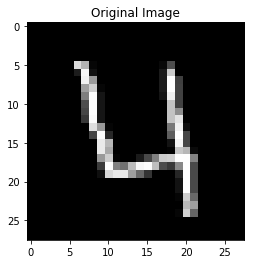

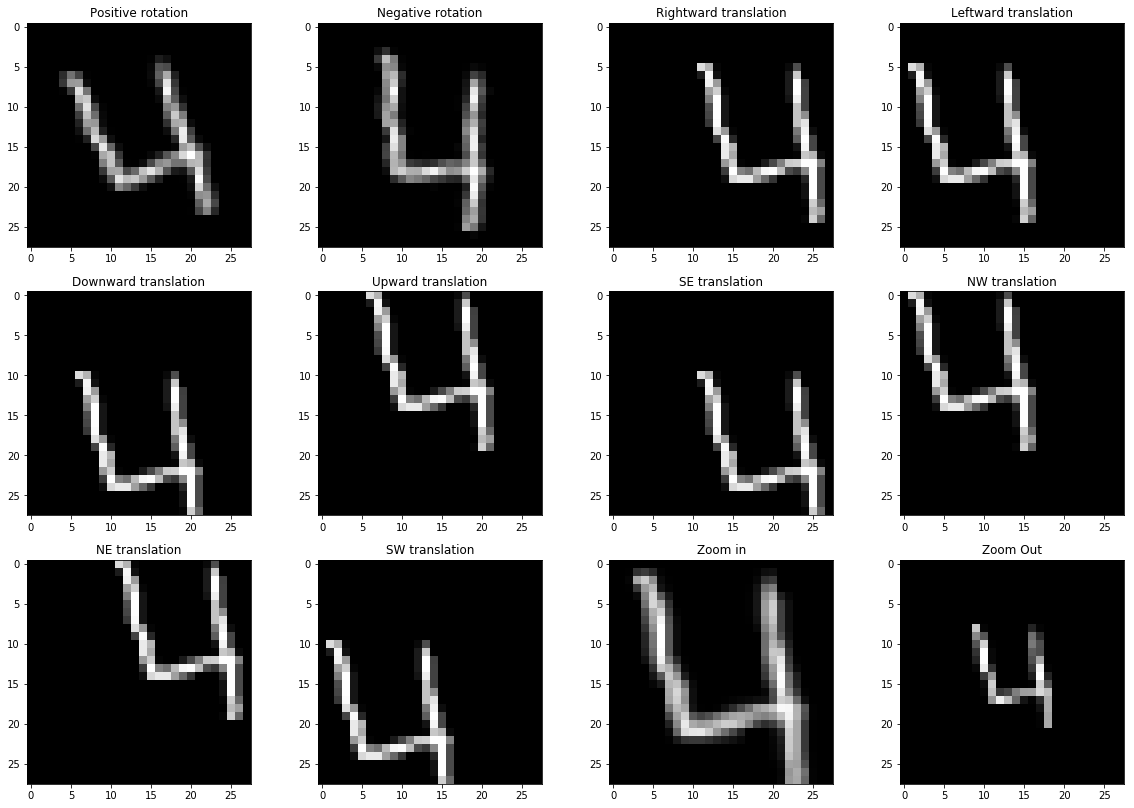

In [20]:
image = train_X[3]
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.show()
matplotlib.rcParams['figure.figsize'] = (20.0, 14.0)
generated_image = rotate_image(image,10)
plt.subplot(3,4,1)
plt.title("Positive rotation")
plt.imshow(generated_image, cmap='gray')
generated_image = rotate_image(image,-10)
plt.subplot(3,4,2)
plt.title("Negative rotation")
plt.imshow(generated_image, cmap='gray')
generated_image = translate_horizontal(image,5)
plt.subplot(3,4,3)
plt.title("Rightward translation")
plt.imshow(generated_image, cmap='gray')
generated_image = translate_horizontal(image,-5)
plt.subplot(3,4,4)
plt.title("Leftward translation")
plt.imshow(generated_image, cmap='gray')
generated_image = translate_vertical(image,5)
plt.subplot(3,4,5)
plt.title("Downward translation")
plt.imshow(generated_image, cmap='gray')
generated_image = translate_vertical(image,-5)
plt.subplot(3,4,6)
plt.title("Upward translation")
plt.imshow(generated_image, cmap='gray')
generated_image = translate_positive_diagonal(image,5)
plt.subplot(3,4,7)
plt.title("SE translation")
plt.imshow(generated_image, cmap='gray')
generated_image = translate_positive_diagonal(image,-5)
plt.subplot(3,4,8)
plt.title("NW translation")
plt.imshow(generated_image, cmap='gray')
generated_image = translate_negative_diagonal(image,5)
plt.subplot(3,4,9)
plt.title("NE translation")
plt.imshow(generated_image, cmap='gray')
generated_image = translate_negative_diagonal(image,-5)
plt.subplot(3,4,10)
plt.title("SW translation")
plt.imshow(generated_image, cmap='gray')
generated_image = zoom(image,5)
plt.subplot(3,4,11)
plt.title("Zoom in")
plt.imshow(generated_image, cmap='gray')
generated_image = zoom(image,-5)
plt.subplot(3,4,12)
plt.title("Zoom Out")
plt.imshow(generated_image, cmap='gray')
plt.show()

**Function to augment data**

In [21]:
def augment_data(image, labels):
    
    '''a function to augment band1 and band2 image'''
    
    # list to store the generated data
    image_generated = []
    labels_generated = []
    
    # iterate through each point in train set
    for i in range(labels.shape[0]):
        
        # rotate by positive degree
        angle = np.random.randint(1,6)
        image_generated.append(rotate_image(image[i],angle)) 
        labels_generated.append(labels[i])
        
        # rotate by negative degree
        angle = np.random.randint(1,6)
        image_generated.append(rotate_image(image[i],-angle)) 
        labels_generated.append(labels[i])
        
        # positive horizontal shift
        shift = np.random.randint(1,3)
        image_generated.append(translate_horizontal(image[i],+shift)) 
        labels_generated.append(labels[i])
        
        # negative horizontal shift
        shift = np.random.randint(1,3)
        image_generated.append(translate_horizontal(image[i],-shift)) 
        labels_generated.append(labels[i])
        
        # positive vertical shift
        shift = np.random.randint(1,3)
        image_generated.append(translate_vertical(image[i],+shift)) 
        labels_generated.append(labels[i])
        
        # negative vertical shift
        shift = np.random.randint(1,3)
        image_generated.append(translate_vertical(image[i],-shift)) 
        labels_generated.append(labels[i])
        
        # translate along positive diagonal in positive direction
        shift = np.random.randint(1,3)
        image_generated.append(translate_positive_diagonal(image[i],+shift)) 
        labels_generated.append(labels[i])
        
        # translate along positive diagonal in negative direction
        shift = np.random.randint(1,3)
        image_generated.append(translate_positive_diagonal(image[i],-shift)) 
        labels_generated.append(labels[i])
        
        # translate along negative diagonal in positive direction
        shift = np.random.randint(1,3)
        image_generated.append(translate_negative_diagonal(image[i],+shift)) 
        labels_generated.append(labels[i])
        
        # translate along negative diagonal in negative direction
        shift = np.random.randint(1,3)
        image_generated.append(translate_negative_diagonal(image[i],-shift)) 
        labels_generated.append(labels[i])
        
        # zoom in image
        zoom_shift = 2
        image_generated.append(zoom(image[i],zoom_shift)) 
        labels_generated.append(labels[i])
        
        # zoom out image
        zoom_shift = 2
        image_generated.append(zoom(image[i],-zoom_shift)) 
        labels_generated.append(labels[i])        
        
    # convert the generated data into numpy array
    image_generated = np.array(image_generated)
    labels_generated = np.array(labels_generated)
    
    # concatenate the generated data to original train set
    image_augmented = np.concatenate((image, image_generated),axis=0)
    labels_augmented = np.concatenate((labels, labels_generated),axis=0)
    
    return image_augmented, labels_augmented

**Augment image and labels of training set**

In [22]:
image_train, labels_train = augment_data(image_train, labels_train)

In [23]:
print("Shape of image_train:",image_train.shape)
print("Shape of image_validation:",image_validation.shape)

Shape of image_train: (518700, 28, 28)
Shape of image_validation: (2100, 28, 28)


In [24]:
image_train = image_train[:,:,:,np.newaxis]
image_validation = image_validation[:,:,:,np.newaxis]

In [25]:
print("Shape of image_train:",image_train.shape)
print("Shape of image_validation:",image_validation.shape)

Shape of image_train: (518700, 28, 28, 1)
Shape of image_validation: (2100, 28, 28, 1)


# **Creating Convolutional Neural Network**

In [26]:
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()
# sess = tf.InteractiveSession()

In [27]:
# image dimensions
width = 28
height = 28
num_channels = 1
flat = width * height
num_classes = 10

**Create Placeholder**

In [28]:
x_image = tf.placeholder(tf.float32, shape=[None,height, width, num_channels])
labels = tf.placeholder(tf.int32, shape=[None, num_classes])
keep_prob = tf.placeholder(tf.float32)

## **Create functions for creating deep learning layers**

In [29]:
def create_weights(shape):
    '''a function to create weight tensor'''
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
 
def create_biases(size):
    '''a function to create bias tensor'''
    return tf.Variable(tf.constant(0.05, shape=[size]))

In [30]:
def create_convolutional_layer(input,
                               num_input_channels,
                               conv_filter_size,
                               max_pool_filter_size,
                               num_filters):  
    
    '''a function to create convoutional layer'''
    
    # create filter for the convolutional layer
    weights = create_weights(shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    
    # create biases
    biases = create_biases(num_filters)
    
    # create covolutional layer
    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1, 1, 1, 1],
                     padding='SAME')
    
    # add the bias to the convolutional layer
    layer += biases
    
    # relu activation layer fed into layer
    layer = tf.nn.relu(layer)
    
    # max pooling to half the size of the image
    layer = tf.nn.max_pool(value=layer,
                            ksize=[1, max_pool_filter_size, max_pool_filter_size, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME')
        
    # return the output layer of the convolution
    return layer

In [31]:
def create_flatten_layer(layer):
    
    '''a function for creating flattened layer from convolutional output'''
    
    # extract the shape of the layer
    layer_shape = layer.get_shape()
    # calculate the number features of the flattened layer
    num_features = layer_shape[1:4].num_elements()
    # create the flattened layer
    layer = tf.reshape(layer, [-1, num_features])
    # return the layer
    return layer

In [32]:
def create_fc_layer(input,          
                    num_inputs,    
                    num_outputs,
                    use_relu=True,
                    dropout = False, 
                    keep_prob = 0.2):
    
    '''a function for creating fully connected layer'''
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)
    
    # matrix multiplication between input and weight matrix
    layer = tf.matmul(input, weights) + biases
    
    # add relu activation if wanted
    if use_relu:
        layer = tf.nn.relu(layer)
        
    # if dropout is wanted add dropout
    if dropout:        
        layer = tf.nn.dropout(layer, keep_prob)
    
    # return layer
    return layer

## **Create Layers of Covnet**

**Parameters of deep learning layers**

In [33]:
conv1_features = 64
conv1_filter_size = 5
max_pool_size1 = 2

conv2_features = 128
conv2_filter_size = 5
max_pool_size2 = 2

fc_layer_size1 = 1024
fc_layer_size2 = 512

**Create First convolutional layer**

In [34]:
layer_conv1 = create_convolutional_layer(input=x_image,
                                         num_input_channels= num_channels,
                                         conv_filter_size = conv1_filter_size,
                                         max_pool_filter_size = max_pool_size1,
                                         num_filters = conv1_features)
layer_conv1

<tf.Tensor 'MaxPool:0' shape=(?, 14, 14, 64) dtype=float32>

**Create second convolutional layer**

In [35]:
layer_conv2 = create_convolutional_layer(input=layer_conv1,
                                         num_input_channels= conv1_features,
                                         conv_filter_size = conv2_filter_size,
                                         max_pool_filter_size = max_pool_size2,
                                         num_filters = conv2_features)
layer_conv2

<tf.Tensor 'MaxPool_1:0' shape=(?, 7, 7, 128) dtype=float32>

**Flatten the output of convolutional layer**

In [36]:
layer_flat = create_flatten_layer(layer_conv2)
layer_flat

<tf.Tensor 'Reshape:0' shape=(?, 6272) dtype=float32>

**Create first fully connected layer**

In [37]:
layer_fc1 = create_fc_layer(input=layer_flat,
                            num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                            num_outputs=fc_layer_size1,
                            use_relu=True,
                            dropout=True,
                            keep_prob=keep_prob)
layer_fc1

<tf.Tensor 'dropout/mul:0' shape=(?, 1024) dtype=float32>

**Create second fully connected layer**

In [38]:
layer_fc2 = create_fc_layer(input=layer_fc1,
                            num_inputs=fc_layer_size1,
                            num_outputs=fc_layer_size2,
                            use_relu=True,
                            dropout=True,
                            keep_prob=keep_prob)
layer_fc2

<tf.Tensor 'dropout_1/mul:0' shape=(?, 512) dtype=float32>

**Create output layer**

In [39]:
output_layer = create_fc_layer(input=layer_fc2,
                     num_inputs = fc_layer_size2,
                     num_outputs = num_classes,
                     use_relu=False)
output_layer

<tf.Tensor 'add_4:0' shape=(?, 10) dtype=float32>

**Create prediction & accuracy metric**

In [40]:
y_pred = tf.nn.softmax(output_layer)
# compute predicted class
y_pred_cls = tf.argmax(y_pred, axis=1, output_type=tf.int32)
# compute true class
y_true_cls = tf.argmax(labels, axis=1, output_type=tf.int32)

In [41]:
# compute correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# compute accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

**Create loss operation**

In [42]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=output_layer,
                                                    labels=labels)
loss = tf.reduce_mean(cross_entropy)

**Create optimizer**

In [43]:
learning_rate = 1e-4
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# **Train Model**

In [44]:
# list to store performance metrics at each iteration
train_loss = []
valid_loss = []
valid_acc = []

# training paramters
train_batch_size = 250
max_iter = 700

In [45]:
# iteration coutner variable
iteration = 0
# var to store the best iteration and accuracy
best_accuracy = 0
best_iteration = 0
# create a saver object
saver = tf.train.Saver(max_to_keep=1)

with tf.Session() as sess:
    
    # initialize variables
    sess.run(tf.global_variables_initializer())

    # while 58 minutes have not elapsed (to finish before the kernel is killed)
    while (time.time()-t1) < 58*60:
        
        # break if max iteration is reached
        if iteration >= max_iter:
            break

        # randmly generate index for batch 
        rand_index_train = np.random.choice(labels_train.shape[0], size=train_batch_size)
        # extract images and labels of the batch
        image_rand_train = image_train[rand_index_train]    
        labels_rand_train = labels_train[rand_index_train]

        # feed dict for batch
        feed_dict_batch =  {x_image: image_rand_train,
                            labels: labels_rand_train,
                            keep_prob: 0.7}
        # feed dict for training
        feed_dict_train =  {x_image: image_rand_train,
                            labels: labels_rand_train,
                            keep_prob: 1.0}
        # feed dict for validation
        feed_dict_validation =  {x_image: image_validation,
                                 labels: labels_validation,
                                 keep_prob:1.0}

        # run optimizer step
        sess.run(train_step, feed_dict=feed_dict_batch)

        # compute train loss and append it to the designated list
        temp_train_loss = loss.eval(session=sess, feed_dict=feed_dict_train)
        train_loss.append(temp_train_loss)
        # compute validation loss and append it to the designated list
        temp_validation_loss = loss.eval(session=sess, feed_dict=feed_dict_validation)
        valid_loss.append(temp_validation_loss)
        # compute validation accuracy and append it to the designated list
        temp_validation_accuracy = accuracy.eval(session=sess, feed_dict=feed_dict_validation)
        valid_acc.append(temp_validation_accuracy)   
        
        # if validation accuracy is better than best recorded so far then update the best valid accuracy
        if temp_validation_accuracy > best_accuracy:
            best_accuracy = temp_validation_accuracy
            best_iteration = iteration
            saver.save(sess, './my-model', global_step = best_iteration)
        
        # print performance information
        print("iterations:",iteration,
              ", train_loss:",temp_train_loss,
              ", valid_loss:", temp_validation_loss,
              ", valid_accuracy:", temp_validation_accuracy)

        iteration += 1

iterations: 0 , train_loss: 2.26309 , valid_loss: 2.30378 , valid_accuracy: 0.119524
iterations: 1 , train_loss: 2.22229 , valid_loss: 2.24069 , valid_accuracy: 0.189048
iterations: 2 , train_loss: 2.20742 , valid_loss: 2.20136 , valid_accuracy: 0.254762
iterations: 3 , train_loss: 2.16654 , valid_loss: 2.166 , valid_accuracy: 0.325714
iterations: 4 , train_loss: 2.12971 , valid_loss: 2.11903 , valid_accuracy: 0.314762
iterations: 5 , train_loss: 2.11922 , valid_loss: 2.06544 , valid_accuracy: 0.320952
iterations: 6 , train_loss: 2.03138 , valid_loss: 2.01346 , valid_accuracy: 0.36
iterations: 7 , train_loss: 2.01408 , valid_loss: 1.96442 , valid_accuracy: 0.47619
iterations: 8 , train_loss: 1.94399 , valid_loss: 1.92007 , valid_accuracy: 0.577143
iterations: 9 , train_loss: 1.95726 , valid_loss: 1.8793 , valid_accuracy: 0.593333
iterations: 10 , train_loss: 1.91957 , valid_loss: 1.83805 , valid_accuracy: 0.614286
iterations: 11 , train_loss: 1.89064 , valid_loss: 1.79974 , valid_accur

iterations: 95 , train_loss: 0.412491 , valid_loss: 0.301502 , valid_accuracy: 0.910476
iterations: 96 , train_loss: 0.452266 , valid_loss: 0.296188 , valid_accuracy: 0.912381
iterations: 97 , train_loss: 0.549584 , valid_loss: 0.292477 , valid_accuracy: 0.912381
iterations: 98 , train_loss: 0.406452 , valid_loss: 0.293916 , valid_accuracy: 0.912381
iterations: 99 , train_loss: 0.52615 , valid_loss: 0.293527 , valid_accuracy: 0.912857
iterations: 100 , train_loss: 0.489975 , valid_loss: 0.289044 , valid_accuracy: 0.915238
iterations: 101 , train_loss: 0.435762 , valid_loss: 0.27993 , valid_accuracy: 0.921429
iterations: 102 , train_loss: 0.441739 , valid_loss: 0.274754 , valid_accuracy: 0.920952
iterations: 103 , train_loss: 0.421637 , valid_loss: 0.272166 , valid_accuracy: 0.925238
iterations: 104 , train_loss: 0.457298 , valid_loss: 0.271516 , valid_accuracy: 0.921429
iterations: 105 , train_loss: 0.474334 , valid_loss: 0.270149 , valid_accuracy: 0.92
iterations: 106 , train_loss: 0.

iterations: 188 , train_loss: 0.282882 , valid_loss: 0.153489 , valid_accuracy: 0.95619
iterations: 189 , train_loss: 0.229174 , valid_loss: 0.150498 , valid_accuracy: 0.957143
iterations: 190 , train_loss: 0.295856 , valid_loss: 0.146951 , valid_accuracy: 0.954762
iterations: 191 , train_loss: 0.260172 , valid_loss: 0.143994 , valid_accuracy: 0.957143
iterations: 192 , train_loss: 0.192555 , valid_loss: 0.142158 , valid_accuracy: 0.957619
iterations: 193 , train_loss: 0.288712 , valid_loss: 0.140661 , valid_accuracy: 0.961905
iterations: 194 , train_loss: 0.222852 , valid_loss: 0.141145 , valid_accuracy: 0.961429
iterations: 195 , train_loss: 0.265062 , valid_loss: 0.141122 , valid_accuracy: 0.962381
iterations: 196 , train_loss: 0.211069 , valid_loss: 0.140719 , valid_accuracy: 0.962381
iterations: 197 , train_loss: 0.273892 , valid_loss: 0.141382 , valid_accuracy: 0.960476
iterations: 198 , train_loss: 0.21563 , valid_loss: 0.147005 , valid_accuracy: 0.954286
iterations: 199 , train

iterations: 281 , train_loss: 0.190747 , valid_loss: 0.102022 , valid_accuracy: 0.969048
iterations: 282 , train_loss: 0.190762 , valid_loss: 0.101026 , valid_accuracy: 0.969048
iterations: 283 , train_loss: 0.208333 , valid_loss: 0.101149 , valid_accuracy: 0.967619
iterations: 284 , train_loss: 0.190208 , valid_loss: 0.0993643 , valid_accuracy: 0.969524
iterations: 285 , train_loss: 0.180268 , valid_loss: 0.0985537 , valid_accuracy: 0.970952
iterations: 286 , train_loss: 0.224758 , valid_loss: 0.0986307 , valid_accuracy: 0.972381
iterations: 287 , train_loss: 0.101753 , valid_loss: 0.100975 , valid_accuracy: 0.972381
iterations: 288 , train_loss: 0.166336 , valid_loss: 0.103505 , valid_accuracy: 0.971429
iterations: 289 , train_loss: 0.21569 , valid_loss: 0.10233 , valid_accuracy: 0.971429
iterations: 290 , train_loss: 0.165068 , valid_loss: 0.0986484 , valid_accuracy: 0.972381
iterations: 291 , train_loss: 0.158518 , valid_loss: 0.0957269 , valid_accuracy: 0.974286
iterations: 292 , 

iterations: 373 , train_loss: 0.169581 , valid_loss: 0.0833469 , valid_accuracy: 0.975238
iterations: 374 , train_loss: 0.115619 , valid_loss: 0.0828785 , valid_accuracy: 0.974286
iterations: 375 , train_loss: 0.116386 , valid_loss: 0.0822722 , valid_accuracy: 0.97619
iterations: 376 , train_loss: 0.0861229 , valid_loss: 0.0817233 , valid_accuracy: 0.977143
iterations: 377 , train_loss: 0.0825002 , valid_loss: 0.0820118 , valid_accuracy: 0.977619
iterations: 378 , train_loss: 0.152415 , valid_loss: 0.0815035 , valid_accuracy: 0.977143
iterations: 379 , train_loss: 0.176332 , valid_loss: 0.0797042 , valid_accuracy: 0.977143
iterations: 380 , train_loss: 0.120841 , valid_loss: 0.0787126 , valid_accuracy: 0.976667
iterations: 381 , train_loss: 0.113983 , valid_loss: 0.0786284 , valid_accuracy: 0.975714
iterations: 382 , train_loss: 0.134611 , valid_loss: 0.0792475 , valid_accuracy: 0.974286
iterations: 383 , train_loss: 0.0740338 , valid_loss: 0.0805237 , valid_accuracy: 0.972857
iteratio

In [46]:
print("Best accuracy is",best_accuracy,"attained at iteration", best_iteration)

Best accuracy is 0.98 attained at iteration 444


In [47]:
# delete unnecessary variables
del(train_data,train_X,train_y,image_train, image_validation, labels_train, labels_validation)

# **Create submission file**

**Extract and format test data**

In [48]:
test_data = pd.read_csv('../input/test.csv')
test_X = test_data[features].as_matrix()
test_X = test_X.reshape((-1,28,28,1))
iD = test_data.index.tolist()
print(test_X.shape)
del(test_data)

(28000, 28, 28, 1)


**Create and save submission csv**

In [49]:
with tf.Session() as sess:    
    
    # restore the best model
    model_path = "./"+"my-model-"+str(best_iteration)
    saver.restore(sess, model_path)
    
    # break the test set into k folds other wise kernel will be out of memory
    n = test_X.shape[0]
    k = 10
    step = n//k
    
    # array to store the prediction
    preds = np.array([])

    # iterate through each fold
    for i in range(k):

        # start and end indices of the fold
        start = (step*i)
        end = (step*(i+1)) 
    
        # feed dictionary for the fold
        feed_dict_test =  {x_image: test_X[start:end],
                           keep_prob: 1.0}

        # evaluate predictions of the fold
        fold_preds = y_pred_cls.eval(session=sess, feed_dict = feed_dict_test)
        
        # append the predictions of the fold to the designated array
        preds = np.append(preds, fold_preds)
        
        print("Finished computing prediction for fold", i)
        
    # convert the prediction vector to int
    preds = preds.astype(np.int)
    
    # save the submission csv file
    submission_path = "./submission.csv"
    submission = pd.DataFrame({"ImageId": iD, "Label": preds})
    submission.to_csv(submission_path, header = True, index=False)

INFO:tensorflow:Restoring parameters from ./my-model-444
Finished computing prediction for fold 0
Finished computing prediction for fold 1
Finished computing prediction for fold 2
Finished computing prediction for fold 3
Finished computing prediction for fold 4
Finished computing prediction for fold 5
Finished computing prediction for fold 6
Finished computing prediction for fold 7
Finished computing prediction for fold 8
Finished computing prediction for fold 9


# **Visualize Performance**

**Visualize loss over iteration**

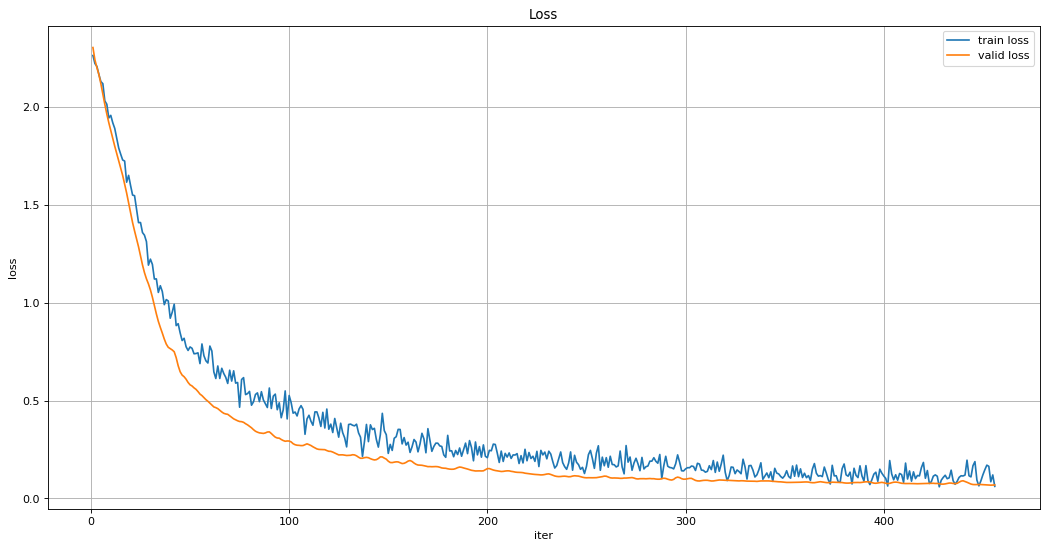

In [50]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
iterations = list(range(1,iteration+1))
plt.plot(iterations, train_loss, label = "train loss")
plt.plot(iterations, valid_loss, label = "valid loss")
plt.title("Loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

**Visualize accuracy over iteration**

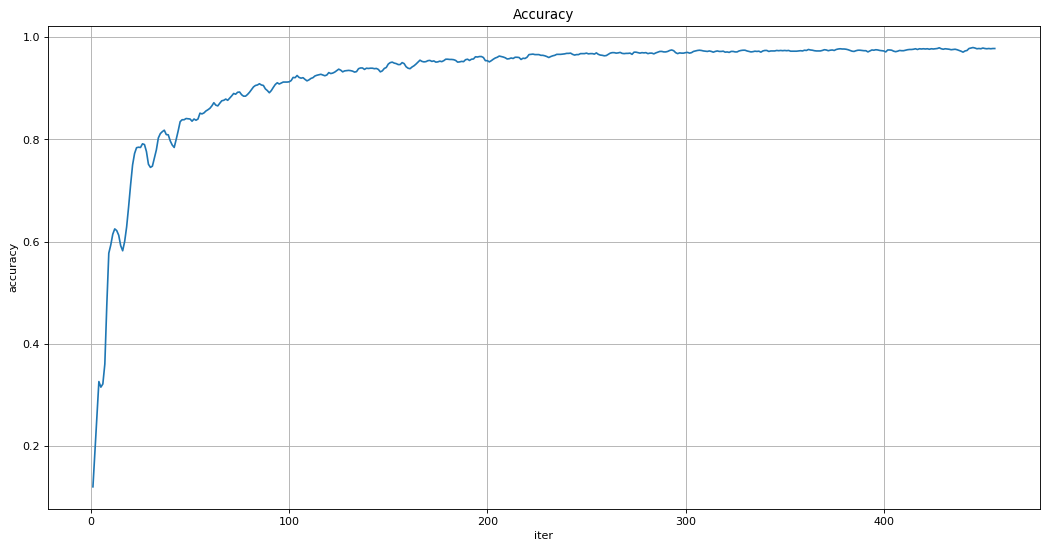

In [51]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iterations, valid_acc, label = "train loss")
plt.title("Accuracy")
plt.xlabel("iter")
plt.ylabel("accuracy")
plt.grid()
plt.show()